Source: https://blog.keras.io/building-autoencoders-in-keras.html

In [19]:
from os.path import join
import pandas as pd

import numpy as np
from numpy.random import choice
from numpy.linalg import norm
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from mpl_toolkits.axes_grid1 import make_axes_locatable

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras import regularizers
from keras.models import Model, model_from_json
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.datasets import fashion_mnist
from keras import backend as K

from sklearn.preprocessing import minmax_scale
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

from scipy.spatial.distance import pdist, cdist

In [20]:
%matplotlib inline
plt.style.use('ggplot')
n_classes = 10 # all examples have 10 classes
cmap = sns.color_palette('Paired', n_classes)
pd.options.display.float_format = '{:,.2f}'.format

## Fashion MNIST Data

In [21]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [22]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [23]:
class_dict = {0: 'T-shirt/top',
              1: 'Trouser',
              2: 'Pullover',
              3: 'Dress',
              4: 'Coat',
              5: 'Sandal',
              6: 'Shirt',
              7: 'Sneaker',
              8: 'Bag',
              9: 'Ankle boot'}
classes = list(class_dict.keys())

## Reshape & normalize Fashion MNIST data

In [24]:
image_size = 28

In [25]:
def data_prep_conv(x, size=image_size):
    return x.reshape(-1, size, size, 1).astype('float32')/255

In [26]:
X_train_scaled = data_prep_conv(X_train)
X_test_scaled = data_prep_conv(X_test)

In [27]:
X_train_scaled.shape, X_test_scaled.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

## Combine training steps into function

In [10]:
def train_autoencoder(path, model, x_train=X_train_scaled, x_test=X_test_scaled):
    callbacks = [EarlyStopping(patience=5, restore_best_weights=True),
                 ModelCheckpoint(filepath=path, save_best_only=True, save_weights_only=True)]
    model.fit(x=x_train, y=x_train, epochs=100, validation_split=.1, callbacks=callbacks)
    model.load_weights(path)
    mse = model.evaluate(x=x_test, y=x_test)
    return model, mse

## Convolutional Autoencoder

### 3-dim input

In [10]:
input_ = Input(shape=(28, 28, 1), name='Input_3D')

### Encoding Layers

In [11]:
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='Encoding_Conv_1')(input_)
x = MaxPooling2D(pool_size=(2, 2), padding='same', name='Encoding_Max_1')(x)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', name='Encoding_Conv_2')(x)
x = MaxPooling2D(pool_size=(2, 2), padding='same', name='Encoding_Max_2')(x)
x = Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same', name='Encoding_Conv_3')(x)
encoded_conv = MaxPooling2D(pool_size=(2, 2), padding='same', name='Encoding_Max_3')(x)

In [12]:
x = Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same', name='Decoding_Conv_1')(encoded_conv)
x = UpSampling2D(size=(2, 2), name='Decoding_Upsample_1')(x)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', name='Decoding_Conv_2')(x)
x = UpSampling2D(size=(2, 2), name='Decoding_Upsample_2')(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', name='Decoding_Conv_3')(x)
x = UpSampling2D(size=(2, 2), name='Decoding_Upsample_3')(x)
decoded_conv = Conv2D(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same', name='Decoding_Conv_4')(x)

In [13]:
autoencoder_conv = Model(input_, decoded_conv)
autoencoder_conv.compile(optimizer='adam', loss='mse')

In [14]:
autoencoder_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_3D (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
Encoding_Conv_1 (Conv2D)     (None, 28, 28, 32)        320       
_________________________________________________________________
Encoding_Max_1 (MaxPooling2D (None, 14, 14, 32)        0         
_________________________________________________________________
Encoding_Conv_2 (Conv2D)     (None, 14, 14, 16)        4624      
_________________________________________________________________
Encoding_Max_2 (MaxPooling2D (None, 7, 7, 16)          0         
_________________________________________________________________
Encoding_Conv_3 (Conv2D)     (None, 7, 7, 8)           1160      
_________________________________________________________________
Encoding_Max_3 (MaxPooling2D (None, 4, 4, 8)           0         
__________

In [15]:
path = 'models/fashion_mnist.autencoder_conv.32.weights.hdf5'

In [21]:
autoencoder_deep, mse = train_autoencoder(path, 
                                          autoencoder_conv, 
                                          x_train=X_train_scaled, 
                                          x_test=X_test_scaled)

Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 5s 87us/step - loss: 0.0222 - val_loss: 0.0159
Epoch 2/100
54000/54000 [==============================] - 4s 80us/step - loss: 0.0149 - val_loss: 0.0139
Epoch 3/100
54000/54000 [==============================] - 4s 80us/step - loss: 0.0133 - val_loss: 0.0127
Epoch 4/100
54000/54000 [==============================] - 4s 81us/step - loss: 0.0124 - val_loss: 0.0122
Epoch 5/100
54000/54000 [==============================] - 4s 80us/step - loss: 0.0119 - val_loss: 0.0116
Epoch 6/100
54000/54000 [==============================] - 4s 80us/step - loss: 0.0115 - val_loss: 0.0115
Epoch 7/100
54000/54000 [==============================] - 4s 80us/step - loss: 0.0111 - val_loss: 0.0111
Epoch 8/100
54000/54000 [==============================] - 4s 81us/step - loss: 0.0108 - val_loss: 0.0122
Epoch 9/100
54000/54000 [==============================] - 4s 81us/step - loss: 0.0106 - val_loss: 0.01

In [22]:
mse, mse**.5

(0.007856989799439907, 0.0886396626767042)

In [16]:
autoencoder_conv.load_weights(path)

In [23]:
reconstructed_images = autoencoder_deep.predict(X_test_scaled)
reconstructed_images.shape

(10000, 28, 28, 1)

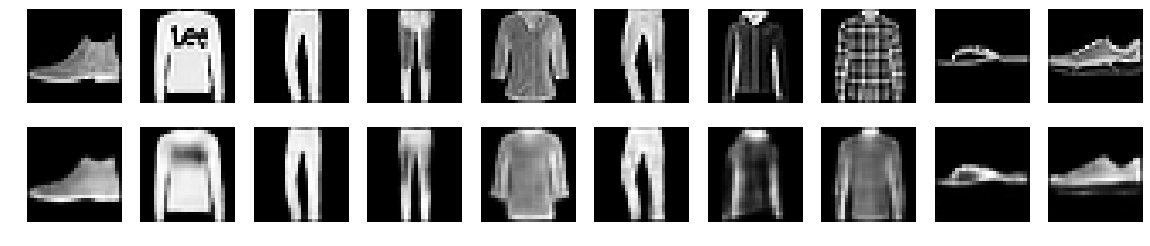

In [26]:
fig, axes = plt.subplots(ncols=n_classes, nrows=2, figsize=(20, 4))
for i in range(n_classes):
    
    axes[0, i].imshow(X_test_scaled[i].reshape(image_size, image_size), cmap='gray')
    axes[0, i].axis('off')

    axes[1, i].imshow(reconstructed_images[i].reshape(image_size, image_size) , cmap='gray')
    axes[1, i].axis('off')

## Denoising Autoencoder

In [28]:
def add_noise(x, noise_factor=.3):
    return np.clip(x  + noise_factor * np.random.normal(size=x.shape), 0, 1)

In [29]:
X_train_noisy = add_noise(X_train_scaled)
X_test_noisy = add_noise(X_test_scaled)

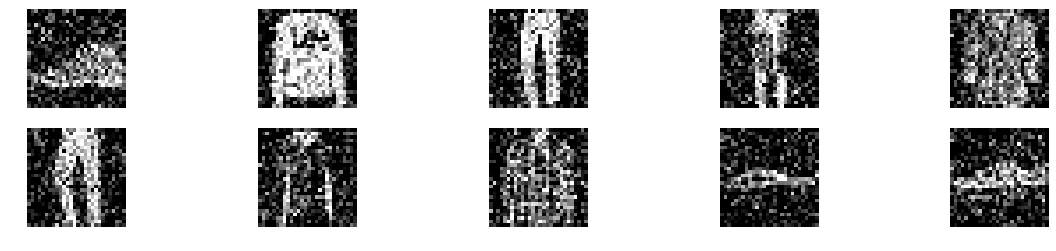

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 4))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(X_test_noisy[i].reshape(28, 28), cmap='gray')
    ax.axis('off')

In [31]:
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='Encoding_Conv_1')(input_)
x = MaxPooling2D(pool_size=(2, 2), padding='same', name='Encoding_Max_1')(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='Encoding_Conv_2')(x)
encoded_conv = MaxPooling2D(pool_size=(2, 2), padding='same', name='Encoding_Max_3')(x)

In [32]:
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='Decoding_Conv_1')(encoded_conv)
x = UpSampling2D(size=(2, 2), name='Decoding_Upsample_1')(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='Decoding_Conv_2')(x)
x = UpSampling2D(size=(2, 2), name='Decoding_Upsample_2')(x)
decoded_conv = Conv2D(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same', name='Decoding_Conv_4')(x)

In [36]:
autoencoder_denoise = Model(input_, decoded_conv)
autoencoder_denoise.compile(optimizer='adam', loss='mse')

In [37]:
path = 'models/fashion_mnist.autencoder_denoise.32.weights'

In [63]:
callbacks = [EarlyStopping(patience=5, restore_best_weights=True),
                 ModelCheckpoint(filepath=path, save_best_only=True, save_weights_only=True)]

In [64]:
autoencoder_denoise.fit(x=X_train_noisy,
                        y=X_train_scaled,
                        epochs=100,
                        batch_size=128,
                        shuffle=True,
                        validation_split=.1,
                        callbacks=callbacks)

Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 2s 39us/step - loss: 0.0242 - val_loss: 0.0152
Epoch 2/100
54000/54000 [==============================] - 2s 34us/step - loss: 0.0143 - val_loss: 0.0135
Epoch 3/100
54000/54000 [==============================] - 2s 34us/step - loss: 0.0130 - val_loss: 0.0125
Epoch 4/100
54000/54000 [==============================] - 2s 34us/step - loss: 0.0122 - val_loss: 0.0118
Epoch 5/100
54000/54000 [==============================] - 2s 34us/step - loss: 0.0115 - val_loss: 0.0111
Epoch 6/100
54000/54000 [==============================] - 2s 34us/step - loss: 0.0109 - val_loss: 0.0107
Epoch 7/100
54000/54000 [==============================] - 2s 34us/step - loss: 0.0105 - val_loss: 0.0103
Epoch 8/100
54000/54000 [==============================] - 2s 35us/step - loss: 0.0102 - val_loss: 0.0102
Epoch 9/100
54000/54000 [==============================] - 2s 34us/step - loss: 0.0100 - val_loss: 0.00

In [38]:
autoencoder_denoise.load_weights(path)

In [39]:
mse = autoencoder_denoise.evaluate(x=X_test_noisy, y=X_test_scaled)
mse

10000/10000 [==============================] - 1s 68us/step


0.008574924531579018

In [40]:
reconstructed_images = autoencoder_denoise.predict(X_test_noisy)
reconstructed_images.shape

(10000, 28, 28, 1)

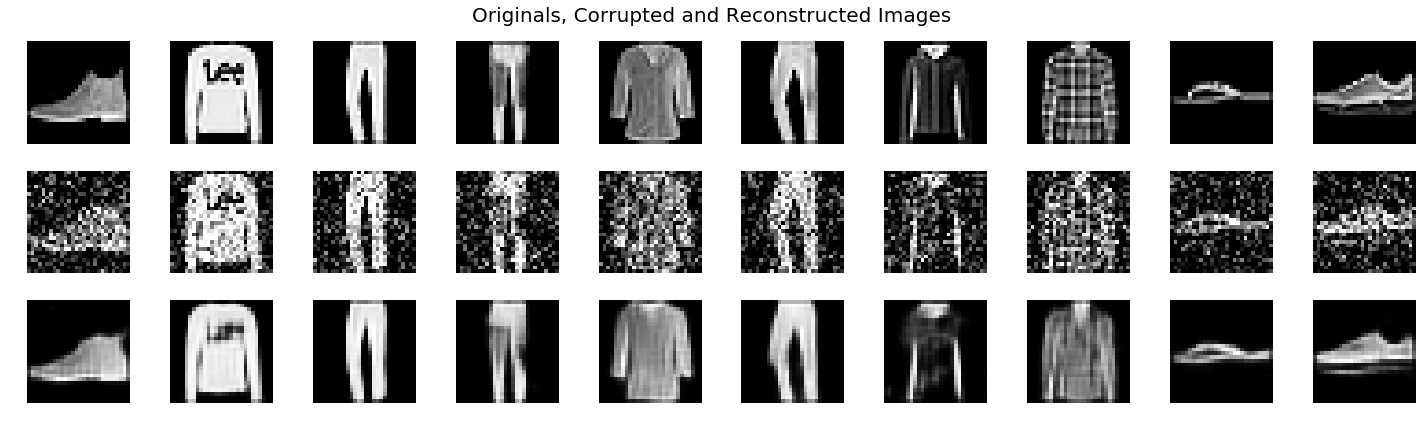

In [46]:
fig, axes = plt.subplots(ncols=n_classes, nrows=3, figsize=(20, 6))
for i in range(n_classes):
    axes[0, i].imshow(X_test[i].reshape(image_size, image_size), cmap='gray')
    axes[0, i].axis('off')
    
    axes[1, i].imshow(X_test_noisy[i].reshape(image_size, image_size), cmap='gray')
    axes[1, i].axis('off')

    axes[2, i].imshow(reconstructed_images[i].reshape(image_size, image_size) , cmap='gray')
    axes[2, i].axis('off')
fig.suptitle('Originals, Corrupted and Reconstructed Images', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig('figures/autoencoder_denoising', dpi=300)